# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Toronto has mainly three different type of clubs, these are The Nightclub, the Strip Club and the Jazz Club. This project aims first to create 3 clusters of neighborhoods according to clubs in and around that neighbourhood, secondly recommend an ideal location for nightlife in Toronto.The target audience of the report is any person/tourist wanting to explore the nightlife in Toronto.

Toronto is known for its clubs, but in choosing the optimum locations; we will aim to detect **locations that atleast have one of the mentioned clubs**, but there should be enough clubs in the vacinity to invite crowds. 

From the data available, candidate neighborhoods will be identified and based on the above criteria  best possible final location will be chosen and suggested. 

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* Clusters that the clubs are grouped into. 
* Proximities of Clubs in different clusters i.e. different type of clubs who are at close proximity to each other will be favoured.
* Number of clubs(Social/Jazz) in Toronto.

Following data sources will be needed to extract/generate the required information:

* Location data specific to Toronto will be scraped of the Wikipedia, this information contains the borough, neighborhood,latitude and longitude.

* All information relating to the type of clubs in the area will be gotten using **Foursquare API**

* Toronto coordinates will be gotten from the internet (a quick google search will be conducted).

Note: *The result observed are greatly influence by the data available in Wikipedia and Folium. Depending on th version (date) the results may differ*

In [1]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
from sklearn.cluster import KMeans
import folium
import pandas as pd
import requests
from bs4 import BeautifulSoup as Soup
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score

read=requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M') #Scrape data from url
soup=Soup(read.text)
soup1=soup.find('tbody')
j=soup1.find_all('tr')

header=[]
upper=[]

for i in soup1.find_all('th'):          #Get header information
    header.append(i.text.strip('\n'))

for i in range(1,len(j)):  #Get data information
    lower=[]
    for td in j[i].find_all("td"):
        lower.append(td.text.strip('\n'))  
    upper.append(lower) 
    
Data=pd.DataFrame(upper,columns=header) #Clean the Dataset
Clean_Data=Data[Data.Borough!='Not assigned'].reset_index(drop=True)
Clean_Data.Neighborhood=Clean_Data.Neighborhood.apply(lambda x: x.replace('/',','))

for i in range(len(Clean_Data.Neighborhood)): #Convert 'Not assigned' Neighborhood to Borough
    if Clean_Data.loc[i,'Neighborhood']=='Not assigned':
        Clean_Data.loc[i,'Neighborhood']=Clean_Data.loc[i,'Borough']
        

df=pd.read_csv('Geospatial_Coordinates.csv')
Canada= Clean_Data.merge(df,how='inner',left_on='Postal code', right_on='Postal Code')
Canada=Canada[['Postal code','Borough','Neighborhood','Latitude','Longitude']]
Canada.rename(columns={'Postal code':'PostalCode'},inplace=True)

The above code is for scaping the data from the web, since I already have the data; I will use the saved dataset.

In [9]:
Canada=pd.read_csv('Canada.csv')
Canada.drop(columns=['Unnamed: 0','PostalCode'],inplace=True)

Using the coordinates in the Canada dataset, a Foursquare search for all venues together with their category is conducted.The results will be saved in a new dataset called Venues.

In [10]:
CLIENT_ID =  # your Foursquare ID
CLIENT_SECRET =  # your Foursquare Secret
VERSION =  # Foursquare API version
LIMIT=500


def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
       
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Venues= getNearbyVenues(names=Canada['Neighborhood'],
                                   latitudes=Canada.Latitude,
                                   longitudes=Canada['Longitude']
                                  ) 


Convert the esults into a columns with dummy variables. Perform a search and only get venue category with word 'club' in it.

### Folium
Lets visualise the neighborhoods involved using Folium.

In [353]:
latitude=43.741667
longitude= -79.373333
Canada_Map = folium.Map(location=[latitude, longitude], zoom_start=11)


# add markers to the map
markers_colors = []
for lat, lon, poi in zip(Canada.Latitude, Canada['Longitude'],Canada['Neighborhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(Canada_Map)
       
Canada_Map

Lets re-arrange the columns into a forms that easy to view and comprehend.

In [25]:
Onehot=pd.get_dummies(Venues['Venue Category'], prefix="", prefix_sep="")
Onehot['Neighborhood']= Venues['Neighborhood'] 
List=[i for i in Onehot.columns if ('club' in i)|('Club' in i)]
fixed_columns =['Neighborhood']+List
Onehot= Onehot[fixed_columns]


Create row and column categories corresponding the different types of clubs in the list. Group the data using neighborhood.

In [28]:
num_top_venues = len(List)
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
Onehot_grouped = Onehot.groupby('Neighborhood').mean().reset_index()

In [62]:
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Onehot_grouped['Neighborhood']


for ind in np.arange(Onehot_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Onehot_grouped.iloc[ind, :], num_top_venues)

## Methodology <a name="data"></a>

Use kMeans clustering to cluster the data into len(List) groups. Insert column with cluster labels; merge the clustered data with the old dataset. This is for identification purposes.

The following actions will be taken to:
* In the first step; we scrapped data from wikipedia, conducted data cleaning and presented the data in datafram. The data was visualised using Folium. 
* The different clubs will be clustered to a value equal to the number of unique venue categories(club categories). KMeans clustering will be the tool used to accomplish the task.
* Determine the neighbourhoods and boroughs of the affected areas.
* Rank the neighbourhoods and boroughs according to frequency.



## Analysis  <a name="data"></a>

In [63]:

from sklearn.metrics import silhouette_score
Onehot_grouped_clustering =Onehot_grouped.drop('Neighborhood', 1)
kclusters= len(List)
WCSS=[]
sil=[]
for i in range(1,kclusters+1):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(Onehot_grouped_clustering)
    WCSS_=kmeans.inertia_
    WCSS.append(WCSS_)
for i in range(2,kclusters+1):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(Onehot_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(Onehot_grouped_clustering,labels, metric = 'euclidean'))
  
 
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Onehot_grouped_clustering)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Onehot_merged = Canada

Onehot_merged = Onehot_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Onehot_merged.drop(axis=0,index=Onehot_merged[(Onehot_merged['Cluster Labels']!=0)&(Onehot_merged['Cluster Labels']!=1)&(Onehot_merged['Cluster Labels']!=2)].index,inplace=True)
Onehot_merged.sort_values('Cluster Labels',inplace=True)
for i in Onehot_merged['Cluster Labels'].unique():
    print( "Cluster {} has {} items".format(i,len(Onehot_merged[Onehot_merged['Cluster Labels']==i])))

Cluster 0.0 has 93 venues
Cluster 1.0 has 3 venues
Cluster 2.0 has 4 venues


Lets visualise the "Club Type" make-up.

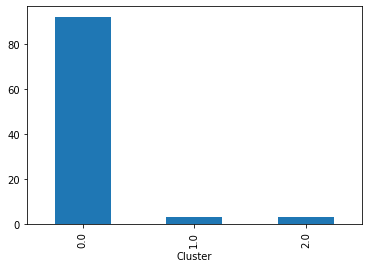

In [352]:
import matplotlib.pyplot as plt
Name=[]
Cluster=[]
Count=[]

for i in Onehot_merged['Cluster Labels'].unique():
    Name.append(Onehot_merged[Onehot_merged['Cluster Labels']==i].groupby('1th Most Common Venue').count().Neighborhood.sort_values(ascending=False).head(1).index[0])
    Cluster.append(i)
    Count.append(Onehot_merged[Onehot_merged['Cluster Labels']==i].groupby('1th Most Common Venue').count().Neighborhood.sort_values(ascending=False).head(1).values[0])

Plot=pd.DataFrame([Name,Cluster,Count]).transpose()
Plot.columns=['Club Type','Cluster','Count']
Plot.set_index('Cluster',inplace=True)
Plot.Count.plot(kind='bar')


Let us see in which top 3 boroughs can the identified clubs be found.

In [262]:

t=Onehot_merged.merge(Onehot,on='Neighborhood')
Borough_Grouped=t[(t['Strip Club']>0)|(t['Nightclub']>0)|(t['Jazz Club']>0)].groupby('Borough').mean()

def Strip(X):
    Strip=[i for i in Borough_Grouped[Borough_Grouped[X]>0].sort_values(X,ascending=False).index[0:3]]
    return Strip

for k in range(len(List)):
    print(List[k] + " "+'are mostly found in: ')
    for i in Strip(List[k]):
        print(i)
    print('\n')
      

Jazz Club are mostly found in: 
Downtown Toronto


Nightclub are mostly found in: 
West Toronto
Downtown Toronto


Strip Club are mostly found in: 
Downtown Toronto




From the identified boroughs, lets us see in which neighborhood  are the identified clubs found.

In [275]:
Neigh_Grouped=t[(t['Strip Club']>0)|(t['Nightclub']>0)|(t['Jazz Club']>0)].groupby(['Borough','Neighborhood']).mean()
Neigh_Grouped

def Neigh(X):
    Neigh=[list(i) for i in Neigh_Grouped[Neigh_Grouped[X]>0].sort_values(X,ascending=False).index]
    
    Neigh=[list(i) for i in Neigh if i[0] in Strip(X)]
    Neigh.sort()
    return Neigh

for k in range(len(List)):
    for v in Strip(List[k]):
        print(List[k] +" " + "in"+" "+ v + " " +'are mostly found in: ')
        for i in Neigh(List[k]):
            if i[0]==v:
                print(i[-1])
        print('\n')



Jazz Club in Downtown Toronto are mostly found in: 
Berczy Park
Kensington Market , Chinatown , Grange Park
St. James Town
Stn A PO Boxes


Nightclub in West Toronto are mostly found in: 
Brockton , Parkdale Village , Exhibition Place


Nightclub in Downtown Toronto are mostly found in: 
Berczy Park
Christie
Richmond , Adelaide , King
University of Toronto , Harbord


Strip Club in Downtown Toronto are mostly found in: 
Church and Wellesley




Get the coordinates of each location.

In [347]:
Lat=[]
Lon=[]
Cluster_=[]
Neigh_=[]
Club=[]
Tracker=[]
for k in range(len(List)):
    for v in Strip(List[k]):
        
        for i in Neigh(List[k]):
            if i[0]==v:
                Lat.extend(list(t.Latitude[t.Neighborhood==i[-1]].unique()))
                Lon.extend(list(t.Longitude[t.Neighborhood==i[-1]].unique()))
                Cluster_.extend(list(t['Cluster Labels'][t.Neighborhood==i[-1]].unique()))
                Neigh_.extend(list(t['Neighborhood'][t.Neighborhood==i[-1]].unique()))
                Tracker=list(t['Neighborhood'][t.Neighborhood==i[-1]].unique())
                Club.append(List[k])
            

Lets visualize the locations. Click the location to see its label.

In [349]:
latitude=43.741667
longitude= -79.373333
My_City_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,name in zip(Lat,Lon,Neigh_,Cluster_,Club):
    label = folium.Popup(str(poi)+" "+name, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(My_City_map_clusters)
       
My_City_map_clusters

## Results and Discussion  <a name="data"></a>

From the analysis done, it was observed that:
* Jazz Clubs are mostly situated in *Downtown Toronto*.
* Nightclub are mostly found in *West Toronto* and *Downtown Toronto*
* Strip Club are mostly found in *Downtown Toronto*

Clubs are mostly situarated between *Downtown Toronto* and *West Toronto*. Jazz Club in *Downtown Toronto* are mostly found in: 
* Berczy Park
* Kensington Market , Chinatown , Grange Park
* St. James Town
* Stn A PO Boxes

Nightclub in *Downtown Toronto* are mostly found in: 
* Berczy Park
* Christie
* Richmond , Adelaide , King
* University of Toronto , Harbord

*West Toronto* also has a nightclub and it is mostly found in:
* Brockton , Parkdale Village , Exhibition Place

Strip Club in *Downtown Toronto* are mostly found in: 
* Church and Wellesley

Downtown Toronto is the nightlife capital of Toronto Canada. *Berczy Park* has both Jazz Clubs and Nightclubs; if you are looking for a strip club, *Church and Wellesley in Downtown Toronto* is the place to go. There is night economy in West Toronto, especially in *Brockton , Parkdale Village , Exhibition Place* but it is not as busy as *Berczy Park*.

## Conclusion  <a name="data"></a>

If you visiting Toronto and you are planning to explore the nightlife, I recommend:
* Downtown Toronto as the starting point. Downtown Toronto is where the nightlife economy is satuarated. The type of clubs to expect in this area are Jazz Clubs, Nightclubs and Strip Clubs.
* West Toronto is also an option if you are looking for a less situarated place.